In [6]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

import cv2
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
# Helper functions
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [8]:
# Loaded a set of images
root_dir = "../dataset/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

X_train = imgs
Y_train = gt_imgs

Loading 100 images
satImage_072.png
Loading 100 images
satImage_072.png


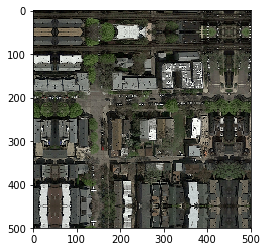

In [71]:
#pad an image (with 3RGB dim with) of padSize by mirroring border
def pad_image(img,padSize):
    return np.lib.pad(img,((padSize,padSize),(padSize,padSize),(0,0)),'reflect')
#pad an ground_truth image 
def pad_gt_img(img,padSize):
    return np.lib.pad(img,((padSize,padSize),(padSize,padSize)),'reflect')
    
plt.imshow((pad_image(imgs[2],50)), cmap='Greys_r')

In [9]:
# Extract patches from a given image
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(imgs)
    IMG_WIDTH = imgs[0].shape[0]
    IMG_HEIGHT = imgs[0].shape[1]
    N_PATCHES_PER_IMAGE = (IMG_WIDTH/IMG_PATCH_SIZE)*(IMG_HEIGHT/IMG_PATCH_SIZE)

    img_patches = [img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = [img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))]

    return numpy.asarray(data)
        
# Assign a label to a patch v
def value_to_class(v):
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch
    df = numpy.sum(v)
    if df > foreground_threshold:
        return [0, 1]
    else:
        return [1, 0]

# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    gt_imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            gt_imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(gt_imgs)
    gt_patches = [img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = numpy.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    labels = numpy.asarray([value_to_class(numpy.mean(data[i])) for i in range(len(data))])

    # Convert to dense 1-hot representation.
    return labels.astype(numpy.float32)


def error_rate(predictions, labels):
    """Return the error rate based on dense predictions and 1-hot labels."""
    return 100.0 - (
        100.0 *
        numpy.sum(numpy.argmax(predictions, 1) == numpy.argmax(labels, 1)) /
        predictions.shape[0])

# Write predictions from neural network to a file
def write_predictions_to_file(predictions, labels, filename):
    max_labels = numpy.argmax(labels, 1)
    max_predictions = numpy.argmax(predictions, 1)
    file = open(filename, "w")
    n = predictions.shape[0]
    for i in range(0, n):
        file.write(max_labels(i) + ' ' + max_predictions(i))
    file.close()

# Print predictions from neural network
def print_predictions(predictions, labels):
    max_labels = numpy.argmax(labels, 1)
    max_predictions = numpy.argmax(predictions, 1)
    print (str(max_labels) + ' ' + str(max_predictions))

# Convert array of labels to an image
def label_to_img(imgwidth, imgheight, w, h, labels):
    array_labels = numpy.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if labels[idx][0] > 0.5:
                l = 1
            else:
                l = 0
            array_labels[j:j+w, i:i+h] = l
            idx = idx + 1
    return array_labels

def img_float_to_uint8(img):
    rimg = img - numpy.min(img)
    rimg = (rimg / numpy.max(rimg) * PIXEL_DEPTH).round().astype(numpy.uint8)
    return rimg

def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = numpy.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = numpy.zeros((w, h, 3), dtype=numpy.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = numpy.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = numpy.zeros((w, h, 3), dtype=numpy.uint8)
    color_mask[:,:,0] = predicted_img*PIXEL_DEPTH

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img


In [10]:
import numpy 

NUM_CHANNELS = 3 # RGB images
PIXEL_DEPTH = 255
NUM_LABELS = 2
TRAINING_SIZE = 20
VALIDATION_SIZE = 5  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 16 # 64
NUM_EPOCHS = 5
RESTORE_MODEL = False # If True, restore existing model instead of training a new one
RECORDING_STEP = 1000

# Set image patch size in pixels
# IMG_PATCH_SIZE should be a multiple of 4
# image size should be an integer multiple of this number!
IMG_PATCH_SIZE = 16

In [13]:
data_dir = '../dataset/training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/' 

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, TRAINING_SIZE)
train_labels = extract_labels(train_labels_filename, TRAINING_SIZE)

num_epochs = NUM_EPOCHS

Loading ../dataset/training/images/satImage_001.png
Loading ../dataset/training/images/satImage_002.png
Loading ../dataset/training/images/satImage_003.png
Loading ../dataset/training/images/satImage_004.png
Loading ../dataset/training/images/satImage_005.png
Loading ../dataset/training/images/satImage_006.png
Loading ../dataset/training/images/satImage_007.png
Loading ../dataset/training/images/satImage_008.png
Loading ../dataset/training/images/satImage_009.png
Loading ../dataset/training/images/satImage_010.png
Loading ../dataset/training/images/satImage_011.png
Loading ../dataset/training/images/satImage_012.png
Loading ../dataset/training/images/satImage_013.png
Loading ../dataset/training/images/satImage_014.png
Loading ../dataset/training/images/satImage_015.png
Loading ../dataset/training/images/satImage_016.png
Loading ../dataset/training/images/satImage_017.png
Loading ../dataset/training/images/satImage_018.png
Loading ../dataset/training/images/satImage_019.png
Loading ../d

In [14]:
train_data.shape

(12500, 16, 16, 3)

In [15]:
c0 = 0
c1 = 0
for i in range(len(train_labels)):
    if train_labels[i][0] == 1:
        c0 = c0 + 1
    else:
        c1 = c1 + 1
print ('Number of data points per class: c0 = ' + str(c0) + ' c1 = ' + str(c1))

print ('Balancing training data...')
min_c = min(c0, c1)
idx0 = [i for i, j in enumerate(train_labels) if j[0] == 1]
idx1 = [i for i, j in enumerate(train_labels) if j[1] == 1]
new_indices = idx0[0:min_c] + idx1[0:min_c]
print (len(new_indices))
print (train_data.shape)
train_data = train_data[new_indices,:,:,:]
train_labels = train_labels[new_indices]

print(train_labels)
train_size = train_labels.shape[0]

c0 = 0
c1 = 0
for i in range(len(train_labels)):
    if train_labels[i][0] == 1:
        c0 = c0 + 1
    else:
        c1 = c1 + 1
print ('Number of data points per class: c0 = ' + str(c0) + ' c1 = ' + str(c1))

Number of data points per class: c0 = 9450 c1 = 3050
Balancing training data...
6100
(12500, 16, 16, 3)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Number of data points per class: c0 = 3050 c1 = 3050


In [48]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

#create model
model = Sequential()

#add model layers
model.add(Conv2D(128, kernel_size=5, activation='relu', input_shape=(16,16,3)))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
#To use the CNN network
#%run cnn.ipynb
#model = createCNN()


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(16, 16, 3..., padding="same")`
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`


In [49]:
model.fit(train_data, train_labels, epochs=6)

Epoch 1/6
6100/6100 [==============================] - 3s 488us/step - loss: 0.6479 - acc: 0.6121
Epoch 2/6
6100/6100 [==============================] - 3s 428us/step - loss: 0.6155 - acc: 0.6618
Epoch 3/6
6100/6100 [==============================] - 3s 438us/step - loss: 0.6000 - acc: 0.6808
Epoch 4/6
6100/6100 [==============================] - 3s 432us/step - loss: 0.5948 - acc: 0.6885
Epoch 5/6
6100/6100 [==============================] - 3s 435us/step - loss: 0.5825 - acc: 0.7008
Epoch 6/6
6100/6100 [==============================] - 3s 434us/step - loss: 0.5799 - acc: 0.6974


In [32]:
score = model.evaluate(train_data, train_labels, batch_size=32)
score

6100/6100 [==============================] - 1s 183us/step


[0.5346355036243063, 0.7344262294691117]

In [19]:
# Get prediction for given input image 
def get_prediction(img):
    data = numpy.asarray(img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE))
    output = model.predict(data)
    output_prediction = output
    img_prediction = label_to_img(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, output_prediction)

    return img_prediction

# Get a concatenation of the prediction and groundtruth for given input file
def get_prediction_with_groundtruth(filename, image_idx):

    imageid = "satImage_%.3d" % image_idx
    image_filename = filename + imageid + ".png"
    img = mpimg.imread(image_filename)

    img_prediction = get_prediction(img)
    cimg = concatenate_images(img, img_prediction)

    return cimg

# Get prediction overlaid on the original image for given input file
def get_prediction_with_overlay(filename, image_idx):

    imageid = "satImage_%.3d" % image_idx
    image_filename = filename + imageid + ".png"
    img = mpimg.imread(image_filename)

    img_prediction = get_prediction(img)
    oimg = make_img_overlay(img, img_prediction)

    return oimg


In [25]:
print ("Running prediction on training set")
prediction_training_dir = "predictions_training/"
if not os.path.isdir(prediction_training_dir):
    os.mkdir(prediction_training_dir)
for i in range(1, TRAINING_SIZE+1):
    pimg = get_prediction_with_groundtruth(train_data_filename, i)
    Image.fromarray(pimg).save(prediction_training_dir + "prediction_" + str(i) + ".png")
    oimg = get_prediction_with_overlay(train_data_filename, i)
    oimg.save(prediction_training_dir + "overlay_" + str(i) + ".png")    

Running prediction on training set


<PIL.Image.Image image mode=RGBA size=400x400 at 0x7FA070213048>


In [ ]:

def train_generator():
    while True:
        for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]
            for id in ids_train_batch.values:
                img = cv2.imread('input/train/{}.jpg'.format(id))
                img = cv2.resize(img, (input_size, input_size))
                mask = cv2.imread('input/train_masks/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (input_size, input_size))
                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                img, mask = randomShiftScaleRotate(img, mask,
                                                   shift_limit=(-0.0625, 0.0625),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-0, 0))
                img, mask = randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


def valid_generator():
    while True:
        for start in range(0, len(ids_valid_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch.values:
                img = cv2.imread('input/train/{}.jpg'.format(id))
                img = cv2.resize(img, (input_size, input_size))
                mask = cv2.imread('input/train_masks/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (input_size, input_size))
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='logs')]

model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(batch_size)),
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(batch_size)))

In [14]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    